## Saját Modell felhasználásával

### Csomagok Betöltése

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.data import AUTOTUNE
from tensorflow import keras
from tensorflow.keras import layers
import json

### Oxford Flowers Adathalmaz Betöltése

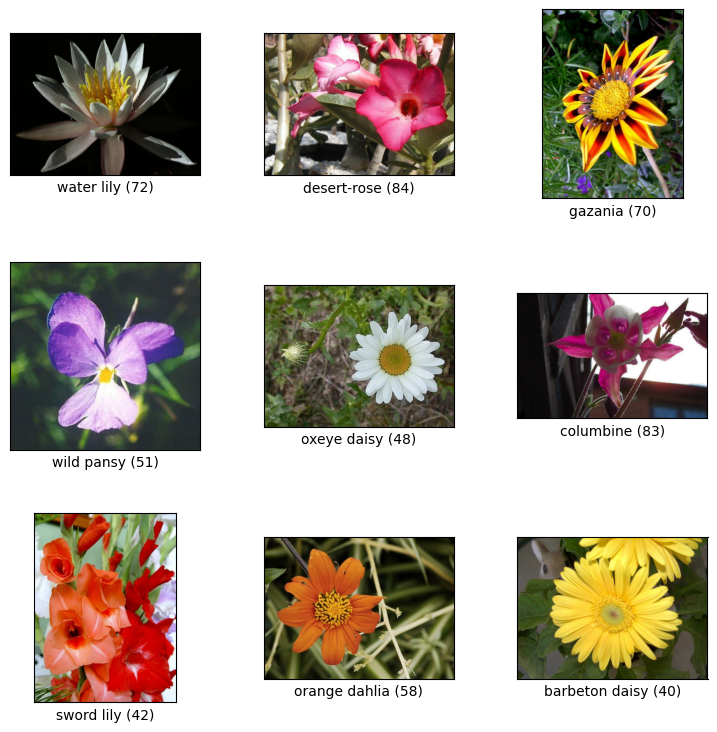

In [2]:
(train,test,valid),info = tfds.load(
        'oxford_flowers102',
        as_supervised=True,
        split=['train','test','validation'],
        with_info=True,
        data_dir='./datasets',
        shuffle_files=True
    )

fig = tfds.show_examples(train,info)

### Címkék Feldolgozása és Halmazok Megszámolása

In [3]:
labels = [ item.strip() for item in open('./datasets/oxford_flowers102/2.1.1/label.labels.txt','r').readlines() ]
num_of_labels = len(labels)

num_training_examples = train.cardinality().numpy()
num_validation_examples = valid.cardinality().numpy()
num_test_examples = test.cardinality().numpy()

### Bemenet Feldolgozása

In [4]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255.0, label

def augment(image, label):
  new_width = new_height = 224
  image = tf.image.resize(image, (new_width, new_height))/255.0
  return image, label

BATCH_SIZE = 32
train_batches = train.cache().shuffle(num_training_examples//4).map(augment).batch(BATCH_SIZE).prefetch(1)
validation_batches = valid.cache().map(augment).batch(BATCH_SIZE).prefetch(1)
test_batches = test.cache().map(augment).batch(BATCH_SIZE).prefetch(1)

Előtte: tf.Tensor(1020, shape=(), dtype=int64)
Utána: tf.Tensor(32, shape=(), dtype=int64)


### TensorBoard Beállítása

In [5]:
from tensorflow.keras.callbacks import TensorBoard
import time

NAME = "oxfordflower_OUR_{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir=f'logs/{NAME}',
                          histogram_freq=1,
                          write_graph=True,
                          write_images=True)


### Modell Elkészítése

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(512, 3, strides=3, activation='relu', padding='same', input_shape = (224,224,3)),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(256, 3,strides=2, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, 3,strides=1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(info.features['label'].num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.fit(train_batches, epochs=10, verbose=1)

Epoch 1/10
32/32 [==============================] - 50s 2s/step - loss: 4.6717 - accuracy: 0.0059
Epoch 2/10
32/32 [==============================] - 46s 1s/step - loss: 4.5652 - accuracy: 0.0157
Epoch 3/10
32/32 [==============================] - 44s 1s/step - loss: 4.3719 - accuracy: 0.0225
Epoch 4/10
32/32 [==============================] - 43s 1s/step - loss: 4.1282 - accuracy: 0.0392
Epoch 5/10
32/32 [==============================] - 44s 1s/step - loss: 3.9908 - accuracy: 0.0578
Epoch 6/10
32/32 [==============================] - 44s 1s/step - loss: 3.8006 - accuracy: 0.0853
Epoch 7/10
32/32 [==============================] - 43s 1s/step - loss: 3.5573 - accuracy: 0.1255
Epoch 8/10
32/32 [==============================] - 45s 1s/step - loss: 3.3153 - accuracy: 0.1627
Epoch 9/10
32/32 [==============================] - 43s 1s/step - loss: 3.1731 - accuracy: 0.1814
Epoch 10/10
32/32 [==============================] - 43s 1s/step - loss: 2.8266 - accuracy: 0.2667


Evaluate on test data
32/32 [==============================] - 13s 395ms/step - loss: 3.3381 - accuracy: 0.2010
test loss, test acc: [3.3380730152130127, 0.20098039507865906]
1/1 [==============================] - 0s 339ms/step
TESTER:  mallow
PREDICT:  mallow


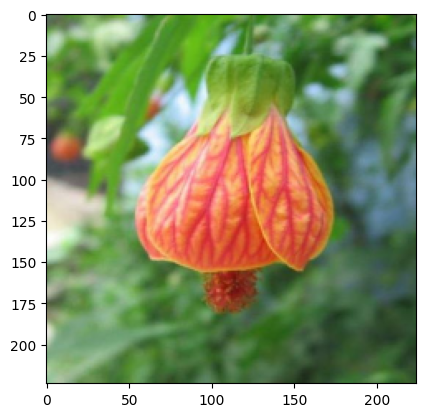

In [8]:
test = valid.cache().shuffle(num_training_examples//4).map(augment).batch(BATCH_SIZE).prefetch(1)

print("Evaluate on test data")
results = model.evaluate(test)
print("test loss, test acc:", results)

img, label = next(iter(train_batches.take(1)))
res = tf.argmax(model.predict(img.numpy()), axis=1)
print("TESTER: ",labels[int(res[0])])
print("PREDICT: ", labels[int(label[0])])
plt.imshow(img[0])

### Modell Mentése

In [9]:
model.save('./models/BOARDED_'+NAME)

INFO:tensorflow:Assets written to: ./models/BOARDED_oxfordflower_OUR_1683656864\assets


INFO:tensorflow:Assets written to: ./models/BOARDED_oxfordflower_OUR_1683656864\assets


### Modell Betöltése
- Kész modell betöltése
- Tesztek futtatása
- Tesztek vizualizációja

` custom_objects={'KerasLayer': hub.KerasLayer} ` - 'hub.KerasLayer' betöltését engedélyezi

In [10]:
model = tf.keras.models.load_model(
  './models/BOARDED_'+NAME)

model.evaluate(validation_batches)

32/32 [==============================] - 15s 469ms/step - loss: 3.3381 - accuracy: 0.2010


[3.3380727767944336, 0.20098039507865906]

### Betöltött Modell Tesztelése
- Zöld a jó
- Piros a rossz

1/1 [==============================] - 0s 392ms/step


<Figure size 1000x900 with 0 Axes>

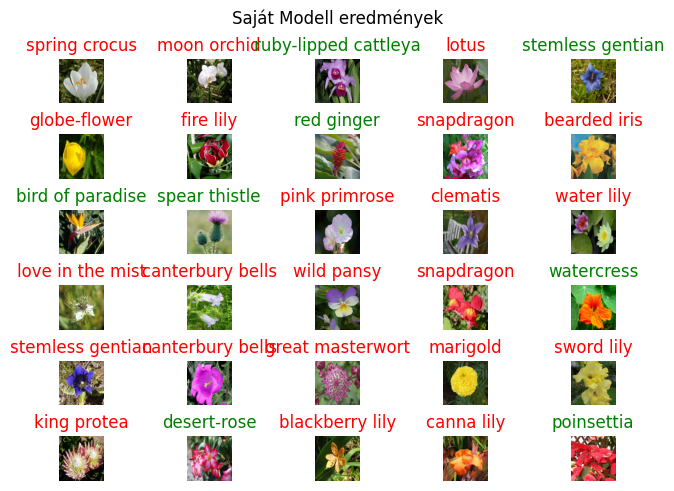

In [17]:
### Predict-hez adatok előkészítése ###
test = valid.cache().shuffle(num_training_examples//4).map(augment).batch(30).prefetch(1)
img, label = next(iter(test.take(1)))
tmp = model.predict(img.numpy())
res = tf.argmax(tmp, axis=1)

plt.figure(figsize=(10,9))
plt.subplots(6,5, constrained_layout=True)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(img[n])
    color = "green" if res[n] == label[n] else "red"
    plt.title(labels[label[n]], color=color)
    plt.axis('off')
    _ = plt.suptitle("Saját Modell eredmények")